In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split

C:\Anaconda3.5\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")

In [3]:
Y_train = train['label']

In [4]:
X_train = train.drop(labels = ['label'], axis = 1)

In [5]:
print(Y_train.value_counts())

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


In [6]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
X_train = X_train/255.0
test = test/255.0

In [9]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

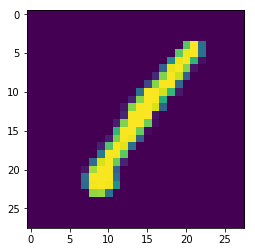

In [10]:
plt.imshow(X_train[0][:,:,0])

In [11]:
def one_hot(label_list, label):
    label = tf.constant(label, name = "label")
    one_hot_matrix = tf.one_hot(label_list, label, axis = 1)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

def batch_generator(X, Y, batch_size):
    cursor = 0
    length = X.shape[0]
    print(length)
    while cursor + batch_size < length:
        image_data = X[cursor : cursor + batch_size]
        label_data = Y[cursor : cursor + batch_size]
        cursor += batch_size
        yield image_data, label_data
    return

In [12]:
#print(Y_train)
Y_train = one_hot(Y_train, 10)
X_train_final, X_val, Y_train_final, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 2)

In [13]:
#print(Y_val)
tf.reset_default_graph()
n_H = 28
n_W = 28
n_C = 1
n_y = 10


X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

In [14]:
W1 = tf.get_variable("W1", [5, 5, 1, 32], initializer = tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable("W2", [5, 5, 32, 32], initializer = tf.contrib.layers.xavier_initializer())
W3 = tf.get_variable("W3", [3, 3, 32, 64], initializer = tf.contrib.layers.xavier_initializer())
W4 = tf.get_variable("W4", [3, 3, 64, 64], initializer = tf.contrib.layers.xavier_initializer())

In [15]:
Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = 'SAME')
A1 = tf.nn.relu(Z1)

Z2 = tf.nn.conv2d(A1, W2, strides = [1, 1, 1, 1], padding = 'SAME')
A2 = tf.nn.relu(Z2)

P1 = tf.nn.max_pool(A2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
D1 = tf.nn.dropout(P1, 0.75)

Z3 = tf.nn.conv2d(D1, W3, strides = [1, 1, 1, 1], padding = 'SAME')
A3 = tf.nn.relu(Z3)

Z4 = tf.nn.conv2d(A3, W4, strides = [1, 1, 1, 1], padding = 'SAME')
A4 = tf.nn.relu(Z4)

P2 = tf.nn.max_pool(A4, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
D2 = tf.nn.dropout(P2, 0.75)

flatten = tf.contrib.layers.flatten(D2)

Z5 = tf.contrib.layers.fully_connected(flatten, 256)

Z6 = tf.contrib.layers.fully_connected(Z5, 10, activation_fn = None)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2( logits = Z6, labels = Y ))

optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(Z6), axis = 1), tf.argmax(Y, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [19]:
num_epochs = 5
batch_size = 128

saver = tf.train.Saver()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    print("Restoring Parameters")
    
    try:
        saver.restore(sess, "./temp/parameters.ckpt")
        print("Parameters Restored")
    except:
        print("Parameters not Available")
        
    for epoch in range(num_epochs):
        
        print("Training on {} epochs".format(epoch+1))
        train_gen = batch_generator(X_train_final, Y_train_final, batch_size)
        iteration = 0
        
        for images, labels in train_gen:
            iteration += 1
            feed_dict = {X: images, Y: labels}
            _, loss = sess.run([optimizer, cost],  feed_dict=feed_dict)
            if (iteration % 50) == 0:
                print('{} iteration on epoch {} completed'.format(iteration,epoch+1))
                acc, loss = sess.run([accuracy, cost], feed_dict = feed_dict)
                print('acc and loss is {} and {}'.format(acc*100,loss))
                saver.save(sess,'./temp/parameters.ckpt')
        
        step = 0
        accuracy_val = 0
        loss_val = 0
        val_gen = batch_generator(X_val, Y_val, batch_size)
        for val_x, val_y in val_gen:
            step += 1
            feed_dict = {X : val_x, Y : val_y}
            
            ac, l = sess.run([accuracy, loss], feed_dict = feed_dict)
            accuaracy_val += ac
            loss_val += l
        
        print("Loss and Accuracy on validation set is {} and {} ".format(loss_val, accuracy_val*100))
            

Restoring Parameters
Parameters not Available
Training on 1 epochs
37800
50 iteration on epoch 1 completed


TypeError: Fetch argument 0.953125 has invalid type <class 'numpy.float32'>, must be a string or Tensor. (Can not convert a float32 into a Tensor or Operation.)